In [5]:
import numpy as np
def parseMGF(mgfData):
    data = mgfData.read_text().split('\n')
    _comments = '#;!/'
    reading_spectrum = False
    params = {}
    masses = []
    intensities = []
    charges = []
    out = {}
    cnt = 0
    pep_mass = 0
    pep_intensity = 0
    out = {}
    for line in data:
        if not reading_spectrum:
            if line.strip() == 'BEGIN IONS': reading_spectrum = True
        else:
            if not line.strip() or any(line.startswith(c) for c in _comments): pass
            elif line.strip() == 'END IONS':
                reading_spectrum = False
                title = params['title'].split()[0]
                if 'pepmass' in params:
                    try:
                        pl = params['pepmass'].split()
                        if len(pl) > 1:
                            pep_mass = float(pl[0])
                            pep_intensity = float(pl[1])
                        elif len(pl) == 1: pep_mass = float(pl[0])
                    except ValueError: print("Error in parsing pepmass value")
                out[cnt] = {'pep_mass': pep_mass,'pep_intensity': pep_intensity,'rtinseconds': params['rtinseconds'],'title': params['title'],'charge': params['charge'],'mz_array': np.array(masses),'intensity_array': np.array(intensities)}
                cnt += 1
            else:
                l = line.split('=', 1)
                if len(l) > 1: params[l[0].lower()] = l[1].strip()
                elif len(l) == 1:  # looks like a peak list ;)
                    l = line.split()
                    if len(l) >= 2000:
                        try:
                            masses.append(float(l[0]))
                            intensities.append(float(l[1]))
                        except ValueError:
                            print("Error in parsing line "+line)
    return out

In [6]:
!pwd

/mnt/f/GD/notebooks


In [7]:
import pathlib
#file = pathlib.Path.cwd().parent.rglob('*.MGF')
file = pathlib.Path('/mnt/f/mgf/20150512_BSA_The-PEG-envelope.mgf')
#file = pathlib.Path.home()/'mgf' / '190128_robin_ 6' / '190128_robin_WT_5.mgf'
print(file.exists())#read_text().split(' '))
out=parseMGF(file)

True


In [8]:
X=[(out[k]['pep_mass']-1.00727647)*int(out[k]['charge'].split('+')[0]) for k, _ in out.items()]
X_mz1=np.array(X).reshape(-1, 1)
print(X_mz1.shape)

(7831, 1)


In [9]:
X=[(out[k]['pep_intensity']) for k, _ in out.items()]
X_int=np.array(X).reshape(-1, 1)
print(X_int.shape)

(7831, 1)


In [10]:
X=[np.float(out[k]['rtinseconds']) for k, _ in out.items()]
X_rt=np.array(X).reshape(-1, 1)
print(X_rt.shape)

(7831, 1)


In [11]:
k=0
print(out[k],X_int[k],X_mz1[k],X_rt[k])

{'pep_mass': 923.591193157233, 'pep_intensity': 597487.125, 'rtinseconds': '1.049124', 'title': '20150512_BSA_The-PEG-envelope.4.4.2 File:"20150512_BSA_The-PEG-envelope.raw", NativeID:"controllerType=0 controllerNumber=1 scan=4"', 'charge': '2+', 'mz_array': array([], dtype=float64), 'intensity_array': array([], dtype=float64)} [597487.125] [1845.16783337] [1.049124]


In [12]:
import matplotlib.pyplot as plt
#plt.hist(X_rt)
#plt.hist(np.log2(X_mz1))
#plt.scatter(X_mz1, int(X_rt))
print(X_mz1, X_rt)

[[1845.16783337]
 [1669.06151796]
 [1757.12071963]
 ...
 [1230.82837932]
 [ 912.55029029]
 [ 868.52364864]] [[1.04912400e+00]
 [1.14588300e+00]
 [1.24253400e+00]
 ...
 [3.29942946e+03]
 [3.29980968e+03]
 [3.30019752e+03]]


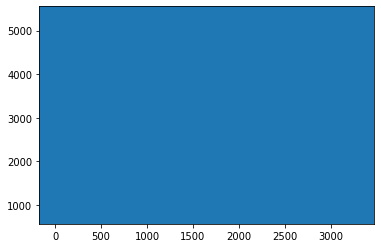

In [13]:
import matplotlib.pyplot as plt
#plt.hist(X_rt)
#plt.hist(np.log2(X_mz1))
plt.scatter(X_rt,X_mz1,X_int)
#plt.scatter(X_rt,X_int)

In [14]:
import ipyvolume as ipv
x, y, z, u, v = ipv.examples.klein_bottle(draw=False)
ipv.figure()
m = ipv.plot_mesh(x, y, z, wireframe=False)
ipv.squarelim()
ipv.show()

In [15]:
import ipyvolume as ipv
import numpy as np
x, y, z = np.random.random((3, 10000))
ipv.quickscatter(x, y, z, size=1, marker="sphere")

In [16]:
v=(zip(X_rt.data,X_mz1.data,X_int.data))
v

In [18]:
import ipyvolume as ipv
import numpy as np
ipv.quickscatter(X_rt,X_mz1,X_int)#, size=1, marker="sphere")

In [ ]:
#!pip install vaex
import vaex
#import scipy
v=vaex.from_arrays(a=X_rt.transpose(), b=X_mz1.transpose(), c=X_int.transpose())
#v = v.count(binby=["a", "b", "c"])
# smooth it for visual pleasure
#v = scipy.ndimage.gaussian_filter(v,1)
v#.shape
v=v.values

In [ ]:
X_rt.transpose()

In [ ]:
import ipyvolume
ipyvolume.quickvolshow(X_int,X_rt,X_mz1)#, lighting=True)

In [ ]:
#!pip install ipyvolume
import pylab
import scipy.optimize as op
import emcee
import numpy as np
import vaex
import scipy.ndimage
import ipyvolume

ds = vaex.from_arrays(a=samples[...,0].copy(), b=samples[...,1].copy(), c=samples[...,2].copy())
# get 2d histogram
v = ds.count(binby=["a", "b", "c"], shape=64)
# smooth it for visual pleasure
v = scipy.ndimage.gaussian_filter(v, 2)

ipyvolume.quickvolshow(v, lighting=True)


In [ ]:
#https://github.com/llSourcell/Gaussian_Mixture_Models/blob/master/intro_to_gmm_%26_em.ipynb
class Gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    def pdf(self, datum):
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

In [ ]:
best_single = Gaussian(np.mean(X_mz1), np.std(X_mz1))
print('Gaussian: μ = {:.2}, σ = {:.2}'.format(best_single.mu, best_single.sigma))

In [ ]:
from scipy import stats
import seaborn as sns
sns.set_style("white")
x = np.linspace(-6, 8, 200)
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(X_mz1, bins=100, kde=False, norm_hist=True)
plt.plot(x, g_single, label='PDF')
plt.legend()

In [ ]:
data=X_mz1
from math import sqrt, log, exp, pi
from random import uniform
class GaussianMixture:
    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=.1, sigma_max=1, mix=.5):
        self.data = data
        #init with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.mix = mix
    def Estep(self):
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den
            wp2 /= den
            # add into loglike
            self.loglike += log(wp1 + wp2)
            # yield weight tuple
            yield (wp1, wp2)
    def Mstep(self, weights):
        (left, rigt) = zip(*weights)
        one_den = sum(left)
        two_den = sum(rigt)
        # compute new means
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(rigt, data))
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)
    def iterate(self, N=1, verbose=False):
    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)
    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)

In [ ]:
# Check out the fitting process
n_iterations = 5
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture(data)
for _ in range(n_iterations):
    try:
        #train!
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        pass

In [ ]:
n_iterations = 20
n_random_restarts = 500
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('\n\nDone. 🙂')

In [ ]:
#from  rulsif import RULSIF
#from cycler import cycler
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import backend

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend
num_outputs=1000
model = Sequential()
#model.add(GaussianNoise(STD_DEV, input_shape=(MAX_WORDS, vectors.dim)))
#model.add(Bidirectional(LSTM(HIDDEN_UNITS, activation='tanh'), merge_mode='concat'))
#model.add(Dropout(DROPOUT_RATIO))
model.add(Dense(num_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer="Adam",metrics=['categorical_accuracy'])

In [ ]:
import keras
base_model=keras.applications.xception.Xception(include_top=True, 
                                                weights='imagenet', 
                                                input_tensor=None, 
                                                input_shape=None, 
                                                pooling=None, 
                                                classes=1000)
x=base_model.output
#x=GlobalAveragePooling4D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
preds=Dense(2,activation='softmax')(x)

In [ ]:
model=Model(inputs=base_model.input,outputs=preds)

In [ ]:
for layer in model.layers[:20]:    layer.trainable=False
for layer in model.layers[20:]:    layer.trainable=True

In [ ]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=train_datagen.flow_from_directory('./subCellular',
                                                  target_size=(299,299),
                                                  color_mode='rgb',
                                                  batch_size=32,
                                                  class_mode='categorical', 
                                                  shuffle=True)
model.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=['accuracy'])
step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,epochs=2)

In [ ]:
model.save('modelMGF.h5')    
!bzip2 'modelMGF.h5'

In [ ]:
import keras
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 16} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [ ]:
import pandas as pd
# import formatter as fm
df = pd.read_csv('Groups.txt',sep='\t')
df.head()

In [ ]:
#check also https://github.com/kusterlab/prosit/blob/master/prosit/prediction.py

In [ ]:
!mkdir  ~/.kaggle
!cp $PWD/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -lthr ~/.kaggle/

In [ ]:
#!$HOME/.local/bin/kaggle datasets download -d piotrgrabo/breastcancerproteomes --force
!$HOME/.local/bin/kaggle competitions download -c human-protein-atlas-image-classification

In [ ]:
!find $HOME -iname train

In [ ]:
!pip install -U -q PyDrive --user
!pip install -U -q google.colab --user

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
model.save('model.h5')    
model_file = drive.CreateFile({'title' : 'model.h5'})
model_file.SetContentFile('model.h5')
model_file.Upload()
drive.CreateFile({'id': model_file.get('id')})

In [ ]:
!ls -ltrh

In [ ]:
outvec=[1 if 'positive' in i.parts[-2] else 0 for i in trainlist]
outvec

In [ ]:
outvecclip=outvec[0:99]

In [ ]:
(outvecclip)

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(MGF, binary_labels, test_size = .2)

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=71, shuffle=True, random_state=42)
batches = [train for test, train  in kf.split(X_train, y_train)]
batches[0].shape

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
test_batches = [t_batch for _, t_batch  in kf.split(X_test, y_test)]
np.histogram(test_batches[9])

In [ ]:
X_train.shape,X_test.shape

In [ ]:
predictions = [result for p in pred for result in p ]
predictions

In [ ]:
from  sklearn.metrics import accuracy_score,log_loss #ytrue ypred
log_loss(y_test, [[p[0],1-p[0]] for p in predictions])

In [ ]:
np.round([p[0] for p in predictions])

In [ ]:
# Compute confusion matrix
confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0])
cnf_matrix = confusion_matrix(y_test, np.round([p[0] for p in predictions]))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
import tensorflow as tf
print(tf.__version__)
import datetime
print(datetime.datetime.now())
tf.keras.backend.clear_session()
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
print("Eager:",tf.executing_eagerly())
print("GPU:",tf.test.is_gpu_available())#:with tf.device("/gpu:0"):
#tf.keras.backend.clear_session()

def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

model = create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

log_dir="/mnt/promec-ns9036k/.tools/guiding-cow-tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=x_train,
          y=y_train,
          epochs=5,
          validation_data=(x_test, y_test),
          callbacks=[tensorboard_callback])

<a href="https://colab.research.google.com/github/animesh/notebooks/blob/master/tfMGF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
*peptide spectra predictor*
- [Novo](https://github.com/nh2tran/DeepNovo)
- [Post](https://github.com/semiller10/postnovo)